## Importing Libraries.

In [ ]:
pip install pyldavis

In [ ]:
import seaborn as sns

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
# python3 -m spacy download en

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Importing Dataset

In [ ]:
from sklearn import datasets
dataa= datasets.fetch_20newsgroups()

In [ ]:
dataa['Target'] = pd.Series(data=dataa)

In [ ]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': dataa.data,
                       'Target': dataa.target})

# get dimensions of data 
news_df.shape

(11314, 2)

In [ ]:
news_df

,News,Target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14
...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1


In [ ]:
# replace target names from target numbers in our news data frame
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataa.target_names[x])

In [ ]:
news_df.head()

,News,Target,Target_name
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## Spitting 20Newsgroup in 6 Groups and viewing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

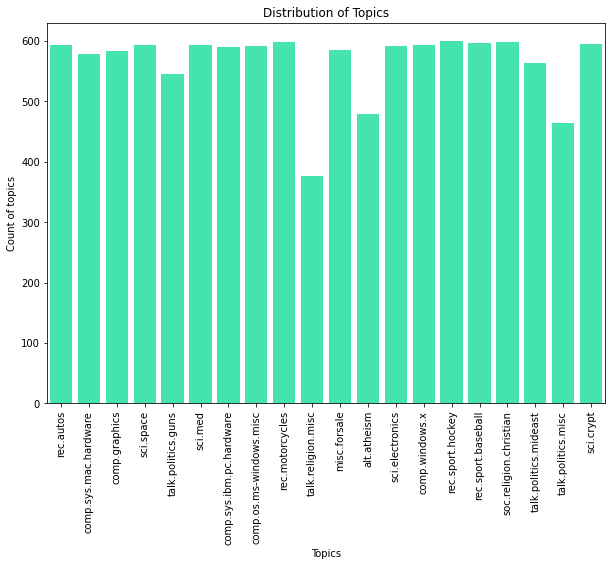

In [ ]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df['Target_name'], color=sns.xkcd_rgb['greenish cyan'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

In [ ]:
news_df['Target_name']=news_df['Target_name'].replace(['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'],['Religion','Tech','Tech','Tech','Tech','Tech','Auto','Auto','Auto','sport','sport','Science','Science','Science','Science','Religion','Politics','Politics','Politics','Religion'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

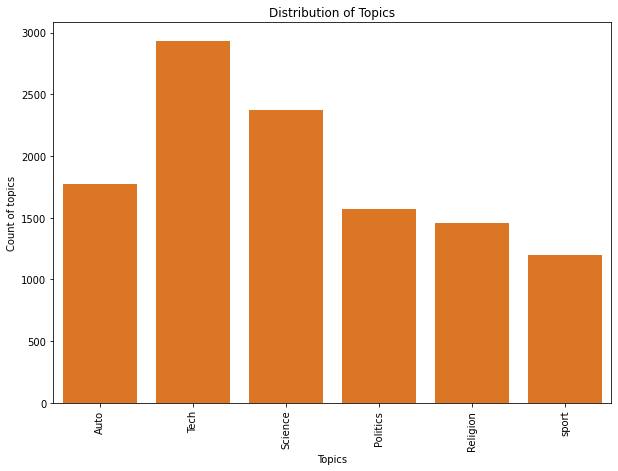

In [ ]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df['Target_name'], color=sns.xkcd_rgb['orange'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

## NLP Preprocessing

In [ ]:
news_df

,News,Target,Target_name
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,Auto
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,Tech
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,Tech
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,Tech
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,Science
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,Science
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,Tech
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,Tech
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,Tech


In [ ]:
# Convert to list
data = news_df.News.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [ ]:
id2word[0]
# here '0' is the word id of the addition.

'addition'

In [ ]:
id2word[1]

'body'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

## Building LDA model with 6 Topics

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"go" + 0.013*"would" + 0.011*"year" + 0.011*"get" + 0.011*"write" + '
  '0.011*"say" + 0.010*"line" + 0.010*"think" + 0.010*"be" + 0.010*"time"'),
 (1,
  '0.013*"people" + 0.013*"say" + 0.013*"would" + 0.011*"write" + 0.010*"may" '
  '+ 0.009*"believe" + 0.008*"think" + 0.008*"reason" + 0.008*"make" + '
  '0.008*"know"'),
 (2,
  '0.012*"program" + 0.011*"file" + 0.009*"use" + 0.009*"window" + '
  '0.008*"include" + 0.007*"available" + 0.007*"run" + 0.007*"system" + '
  '0.007*"software" + 0.007*"also"'),
 (3,
  '0.032*"line" + 0.019*"would" + 0.016*"write" + 0.012*"host" + '
  '0.010*"article" + 0.010*"drive" + 0.010*"get" + 0.010*"use" + 0.009*"thank" '
  '+ 0.009*"be"'),
 (4,
  '0.047*"ax" + 0.040*"max" + 0.020*"patient" + 0.012*"space" + 0.010*"launch" '
  '+ 0.009*"di_di" + 0.009*"orbit" + 0.008*"disease" + 0.008*"tumor" + '
  '0.008*"satellite"'),
 (5,
  '0.011*"government" + 0.009*"people" + 0.008*"public" + 0.008*"state" + '
  '0.007*"gun" + 0.006*"kill" + 0.005*"a

## Measuring topic coherence
### Topic Coherence Metric assesses is how well a topic is ‘supported’ by a text set (called reference corpus)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.116451825227598

Coherence Score:  0.4372555642195248


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.146281 -0.033487       1        1  24.540632
0     -0.160427 -0.144503       2        1  22.328179
3     -0.162292 -0.084302       3        1  21.229432
2      0.035535  0.257748       4        1  15.437675
5      0.049628  0.157583       5        1  13.717003
4      0.383837 -0.153039       6        1   2.747078, topic_info=          Term          Freq         Total Category  logprob  loglift
19        line  11664.000000  11664.000000  Default  30.0000  30.0000
113         go   5638.000000   5638.000000  Default  29.0000  29.0000
3685        ax   1462.000000   1462.000000  Default  28.0000  28.0000
1780       max   1238.000000   1238.000000  Default  27.0000  27.0000
300        say   6412.000000   6412.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3309     taste    105.741184    146.961776   Topic6  -5.6813   3.2655
1227     earth    138.612119    430.498803   Topic6  -5.4106   2.4614
3304      pain    120.928990    338.120326   Topic6  -5.5471   2.5664
703      study    123.887108    561.087804   Topic6  -5.5229   2.0841
686   research    111.303706    577.175486   Topic6  -5.6301   1.9487

[381 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1211      1  0.927958   accept
1211      4  0.071694   accept
176       1  0.097940  address
176       3  0.023045  address
176       4  0.800800  address
...     ...       ...      ...
197       1  0.310489    write
197       2  0.286061    write
197       3  0.403380    write
40        2  0.808315     year
40        5  0.191244     year

[624 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3, 6, 5])

## Installing LDA Mallet Model.
### Gensim uses a Variational Bayes sampling method which is faster but less precise than Mallet's Gibbs Sampling

In [ ]:
from gensim.models.wrappers import LdaMallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-05-01 11:48:58--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-05-01 11:48:58--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  44.2MB/s    in 0.3s    

2022-05-01 11:48:59 (44.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
!pip install --upgrade gensim==3.8

     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

## LDA Mallet model.

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('drive', 0.037224172237251),
   ('card', 0.028393212457242505),
   ('problem', 0.0262469538777974),
   ('system', 0.024078338438149747),
   ('driver', 0.01976346441905699),
   ('work', 0.018824476290549754),
   ('bit', 0.015090880636723378),
   ('disk', 0.014353104250039125),
   ('scsi', 0.013525900422544658),
   ('machine', 0.01332468868072168)]),
 (15,
  [('people', 0.01675617168311061),
   ('leave', 0.014986886474334956),
   ('time', 0.013571458307314432),
   ('man', 0.013051080304733358),
   ('back', 0.010365929811415013),
   ('woman', 0.010220223970692312),
   ('live', 0.009887182049040422),
   ('day', 0.009699845968111236),
   ('start', 0.009533325007285293),
   ('happen', 0.009283543566046376)]),
 (1,
  [('car', 0.03413368494927798),
   ('bike', 0.013483337232300462),
   ('power', 0.011207758235681929),
   ('ride', 0.009463856574721933),
   ('light', 0.009442589481295591),
   ('engine', 0.008060228408583399),
   ('ground', 0.007719954913761936),
   ('turn', 0.0077199549

In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

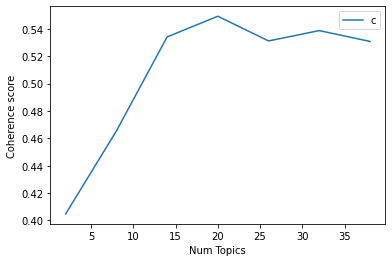

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4047
Num Topics = 8  has Coherence Value of 0.4654
Num Topics = 14  has Coherence Value of 0.5341
Num Topics = 20  has Coherence Value of 0.5492
Num Topics = 26  has Coherence Value of 0.5312
Num Topics = 32  has Coherence Value of 0.5387
Num Topics = 38  has Coherence Value of 0.5308


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.051*"line" + 0.026*"bit" + 0.024*"problem" + 0.022*"color" + '
  '0.021*"image" + 0.015*"point" + 0.013*"monitor" + 0.012*"find" + '
  '0.012*"screen" + 0.009*"quality"'),
 (1,
  '0.017*"people" + 0.012*"government" + 0.010*"israeli" + 0.010*"war" + '
  '0.009*"attack" + 0.008*"turkish" + 0.008*"state" + 0.008*"country" + '
  '0.008*"world" + 0.008*"force"'),
 (2,
  '0.193*"ax" + 0.156*"max" + 0.152*"line" + 0.105*"host" + 0.044*"nntp_poste" '
  '+ 0.034*"reply" + 0.032*"organization" + 0.011*"nntp_posting" + '
  '0.009*"distribution_usa" + 0.009*"ca"'),
 (3,
  '0.022*"people" + 0.016*"man" + 0.013*"life" + 0.011*"religion" + '
  '0.011*"love" + 0.010*"christian" + 0.010*"church" + 0.009*"world" + '
  '0.009*"make" + 0.008*"word"'),
 (4,
  '0.026*"gun" + 0.025*"law" + 0.020*"people" + 0.020*"state" + 0.014*"case" + '
  '0.011*"make" + 0.011*"crime" + 0.010*"person" + 0.010*"weapon" + '
  '0.008*"police"'),
 (5,
  '0.034*"line" + 0.031*"buy" + 0.026*"price" + 0.024*"sell" + 0.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.1603,"car, bike, power, ride, light, engine, wire, g...",From: (wheres my thing) Subject: WHAT car is t...
1,1,17.0,0.1414,"drive, card, problem, system, driver, work, ru...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,19.0,0.1212,"good, thing, make, time, bad, lot, put, back, ...",From: (Thomas E Willis) Subject: PB questions....
3,3,6.0,0.0919,"write, article, line, organization, opinion, h...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,7.0,0.1413,"file, number, line, read, book, program, follo...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,4.0,0.3095,"gun, law, people, state, case, make, crime, pe...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,18.0,0.1038,"post, mail, group, send, information, address,...",From: (brian manning delaney) Subject: Brain T...
7,7,17.0,0.5048,"drive, card, problem, system, driver, work, ru...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,8.0,0.1349,"window, program, version, software, applicatio...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,17.0,0.1459,"drive, card, problem, system, driver, work, ru...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4812,"line, bit, problem, color, image, point, monit...",From: (Ronald W. Schmidt) Subject: outlining o...
1,1.0,0.7119,"people, government, israeli, war, attack, turk...",From: Center for Policy Research Subject: Fina...
2,2.0,0.9712,"ax, max, line, host, nntp_poste, reply, organi...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
3,3.0,0.5885,"people, man, life, religion, love, christian, ...",From: (Marida Ignacio) Subject: Refusing Divin...
4,4.0,0.6067,"gun, law, people, state, case, make, crime, pe...",From: (Steve Manes) Subject: Re: Gun Control (...


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,10.0,"car, bike, power, ride, light, engine, wire, g...",588.0,0.0520
1.0,17.0,"drive, card, problem, system, driver, work, ru...",508.0,0.0449
2.0,19.0,"good, thing, make, time, bad, lot, put, back, ...",308.0,0.0272
3.0,6.0,"write, article, line, organization, opinion, h...",687.0,0.0607
4.0,7.0,"file, number, line, read, book, program, follo...",512.0,0.0453
...,...,...,...,...
11309.0,15.0,"drug, study, problem, food, effect, doctor, fi...",NaN,NaN
11310.0,17.0,"drive, card, problem, system, driver, work, ru...",NaN,NaN
11311.0,17.0,"drive, card, problem, system, driver, work, ru...",NaN,NaN
11312.0,0.0,"line, bit, problem, color, image, point, monit...",NaN,NaN
